# LEARNING OBJECTIVE

This notebook shows how to numerically compute the streamlines, pathlines and streaklines of a given a planar velocity field in Cartesian coordinates. Interactive plots allow varying time through a slider to understand the effect of flow unsteadiness.

# PRELIMINARIES

[run the next cell to setup Python environment customizations and load packages]

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib import pyplot as plt
size = 16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25}
plt.rcParams.update(params)
%matplotlib inline

import numpy as np
import scipy.integrate as spint

# for Colab only: to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

Check out these examples also using Python: https://web.iitd.ac.in/~pnair/post/flow_visualization/

# DEFINE YOUR VELOCITY FIELD

[execute the cell below for the flow field you wish to visulaize, whichever one you execute last is the one it will use]

## Try a velocity field of your own

You need to fill in all the "`# fill in ...`" with something reasonable.

In [2]:
# define any constants that arise
# fill in ...

# x-component u of \vec{V}
def x_velocity(x,y,z,t):
  return # fill in ...

# y-component v of \vec{V}
def y_velocity(x,y,z,t):
  return # fill in ...

# z-component w of \vec{V}
# we won't do examples with z-velocity here, so it is always = 0
def z_velocity(x,y,z,t):
  return 0

## Example from ME 30800 Lecture 02

A fluid flow field is given by
$$ \vec{V}(x,y,z,t) = a x^2 \hat{i} + b x y \hat{j} + 0 \hat{k}, $$
where $a=5~\mathrm{m}^{-1}\mathrm{s}^{-1}$ and $b=-3~\mathrm{m}^{-1}\mathrm{s}^{-1}$.

*   This velocity field has **two components** ($u= ax^2$ and $v=bxy$), "living" in the $(x,y)$ plane (no velocity in $z$-direction, meaning 0 component in $\hat{k}$).
* This velocity field is **two dimensional** because only $x$ and $y$ (two of the independent variables) are present in the definition.
* This velocity field is **steady** because $t$ does not appear in the definition.

In [3]:
# define any constants that arise
a = 5
b = -3

# x-component u of \vec{V}
def x_velocity(x,y,z,t):
  return a*x**2

# y-component v of \vec{V}
def y_velocity(x,y,z,t):
  return b*x*y

# z-component w of \vec{V}
# we won't do show examples with z-velocity here, so it is always = 0
def z_velocity(x,y,z,t):
  return 0

## Recommended problem from ME 30800 Lecture 03

A fluid flow field is given by
$$ \vec{V}(x,y,z,t) = a x (b+2t) \hat{i} + c y \hat{j} + 0 \hat{k}, $$
where $a,b,c$ are constants with suitable units.

*   This velocity field has **two components** $u= ax(b+2t)$ and $v=cy$\, "living" in the $(x,y)$ plane.
* This velocity field is **two dimensional** because only $x$ and $y$ (two of the independent variables) are present in the definition.
* This velocity field is **unsteady** because $t$ appears in the definition.

In [4]:
# define any constants that arise
a = 1
b = 1
c = 1

# x-component u of \vec{V}
def x_velocity(x,y,z,t):
  return a*x*(b+2*t)

# y-component v of \vec{V}
def y_velocity(x,y,z,t):
  return c*y

# z-component w of \vec{V}
# we won't do examples with z-velocity here, so it is always = 0
def z_velocity(x,y,z,t):
  return 0

# MAKE COOL PLOTS

## The velocity field itself

First, let us visualize the flow as a collection of arrows (called a "[quiver](https://en.wikipedia.org/wiki/Quiver) plot"), as in vector calculus.

In case the flow field is unsteady, we'd also like to be able to vary time $t$. We'll use a slider for that.

In [5]:
def plot_flow_field(t):
  # define the length of the square domain to show the streamlines on
  length = 3
  # '10j' means we want 10 points
  y, x = np.mgrid[-length:length:10j, -length:length:10j]

  # evaluate the velocity
  u = x_velocity(x,y,0,t)
  v = y_velocity(x,y,0,t)

  # define the plotting figure and its axes
  fig, ax = plt.subplots(tight_layout=True)
  ax.set(xlim=(-length, length), ylim=(-length, length))
  ax.set_ylabel('$y$ [m]')
  ax.set_xlabel('$x$ [m]')

  # plotting a velocity field with arrows is called a 'quiver plot'
  # a quiver is a bag an archer holds their arrows :)
  q = ax.quiver(x, y, u, v, color='blue')

  # scale for arrows in top right corner
  arrow_key_size = 10
  ax.set_title(' length of arrow shown is ' + str(arrow_key_size) + ' m/s ')
  ax.quiverkey(q, length*0.8, length*1.1, arrow_key_size,
               r'$\vec{V}$ [m/s]', labelpos='E', coordinates='data')

  plt.show()

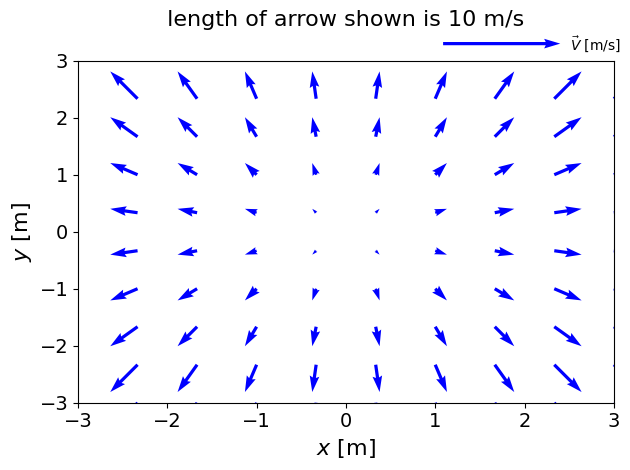

In [6]:
plot_flow_field(0)

In [7]:
tfinal = 10

interact(plot_flow_field, t = widgets.FloatSlider(value=0,
                                                  min=0,
                                                  max=tfinal,
                                                  step=(tfinal-0)/50));

interactive(children=(FloatSlider(value=0.0, description='t', max=10.0, step=0.2), Output()), _dom_classes=('w…

## An instanteneous streamline going through a given point

Give a point $(x_0,y_0)$ through which the streamline should pass at time $t_0$.

In [8]:
x0 = 1
y0 = 1
t0 = 0.1

# define the length of the square domain to show the streamlines on
length = 3

Use [matplotlib](https://matplotlib.org/stable/gallery/images_contours_and_fields/plot_streamplot.html) utilities to make the streamline plot. These utility functions will solve the basic equation
$$ \frac{dy}{dx} = \frac{v(x,y,z,t)}{u(x,y,z,t)} $$
for a streamline $y(x)$ passing through $(x_0,y_0)$. We'll assume $z=0$, meaning none of our velocity fields depend on $z$.

[Challenge for you on your own: adapt the time slider from the other examples to be able to vary the time at shich the instanteneous streamlines are shown.]

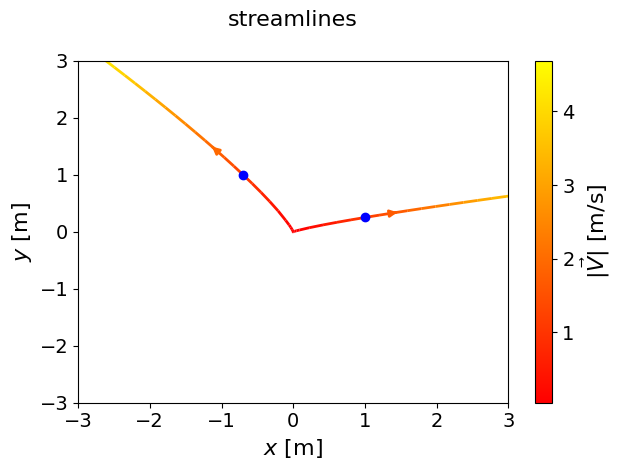

In [9]:
# here you can actually add as many starting points as you'd like
# in the array of x coords and the array of correspoing y coords;
# separate them by commas, as in the example shown
seed_points = np.array([[-0.7*x0, x0], [y0, 0.25*y0]])

# define the length of the square domain to show the streamlines on
length = 3
y, x = np.mgrid[-length:length:100j, -length:length:100j]

# evaluate the velocity
u = x_velocity(x,y,0,t0)
v = y_velocity(x,y,0,t0)

# magnitude of the velocity, to color the streamlines
speed = np.sqrt(u**2 + v**2)

# define the plotting figure and its axes
fig, ax = plt.subplots(tight_layout=True)
ax.set(xlim=(-length, length), ylim=(-length, length))
ax.set_ylabel('$y$ [m]')
ax.set_xlabel('$x$ [m]')
ax.set_title('streamlines')

# plot the streamline(s)
strm = ax.streamplot(x, y, u, v, color=speed, linewidth=2,
                     cmap='autumn', start_points=seed_points.T)
cbar = plt.colorbar(strm.lines)
cbar.set_label(r'$|\vec{V}|$ [m/s]')

# display the starting points with blue symbols
ax.plot(seed_points[0], seed_points[1], 'bo')

plt.show()

For an extra neat trick, we have colored the streamline based on the velocity magnitute, $|\vec{V}| = \sqrt{u^2+v^2}$ at the points $(x,y)$ it passed through. The color bar gives the values.

### Showing streamline is tangent to velocity field

If we wanted to check this definition of the streamline, we can combine the previous two (quiver and streamline) plots.

[this assumes you've ran the previous cells above and defined all variables]

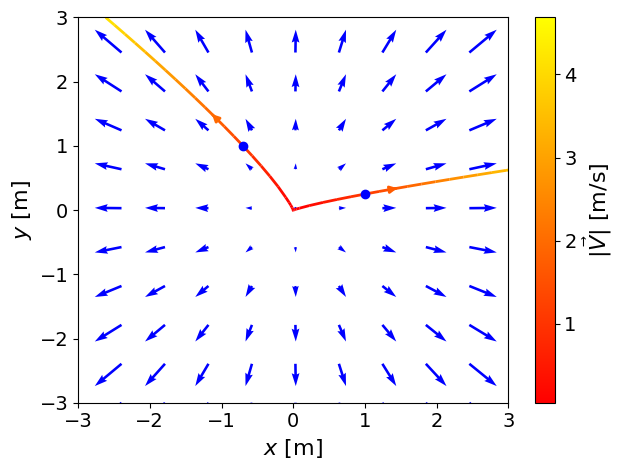

In [10]:
# define the plotting figure and its axes
fig, ax = plt.subplots(tight_layout=True)
ax.set(xlim=(-length, length), ylim=(-length, length))
ax.set_ylabel('$y$ [m]')
ax.set_xlabel('$x$ [m]')

# magnitude of the velocity, to color the streamlines
speed = np.sqrt(u**2 + v**2)

# plot the streamline(s)
strm = ax.streamplot(x, y, u, v, color=speed, linewidth=2,
                     cmap='autumn', start_points=seed_points.T)
cbar = plt.colorbar(strm.lines)
cbar.set_label(r'$|\vec{V}|$ [m/s]')

# plotting a velocity field with arrows is called a 'quiver plot'
# a quiver is a bag an archer holds their arrows :)
# ::10 skips 10 points, so that we don't have too many overlapping arrows
q = ax.quiver(x[::10,::10], y[::10,::10], u[::10,::10], v[::10,::10], color='blue')

# scale for arrows in top right corner
#arrow_key_size = 10
#ax.set_title(' length of shown arrow is ' + str(arrow_key_size) + ' m/s ')
#ax.quiverkey(q, length*0.8, length*1.1, arrow_key_size,
#             r'$\vec{V}$ [m/s]', labelpos='E', coordinates='data')

# display the starting points with blue symbols
ax.plot(seed_points[0], seed_points[1], 'bo')

plt.show()

## A pathline starting at a given point at a given time

A key difference is that the equation of a pathline is an "initial value problem", we solve two coupled ODEs
$$ \left\{ \begin{align*} \frac{d x_p}{dt} &= u\big(x_p(t),y_p(t),z_p(t),t\big),\\ \frac{d y_p}{dt} &= v\big(x_p(t),y_p(t),z_p(t),t\big), \end{align*} \right. $$
from a starting point in time $t=t_0$ to a stopping point in time $t = t_\mathrm{final}$. Then make a **parametric plot** $\big(x_p(t),y_p(t)\big)$ to show the pathline. Again we assume $z_p=0$ (no $z$-dependence).

We still need a starting point $(x_0,y_0)$.

In [11]:
t0 = 0
tfinal = 3

x0 = 0.1
y0 = 2.1

Then, we setup a way to solve these ODEs using numerical methods from [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

In [12]:
def pathline_ode(t, position):
    x, y = position
    z = 0 # again
    u = x_velocity(x,y,z,t)
    v = y_velocity(x,y,z,t)
    return [u, v]

We use a dynamic plot with a slider to vary $t$.

In [13]:
def plot_pathline(t, t0=0, style='solid', color='black'):
  # define the length of the square domain to show the pathlines on
  length = 10

  # define the plotting figure and its axes
  fig, ax = plt.subplots(tight_layout=True)
  ax.set(xlim=(-length, length), ylim=(-length, length))
  ax.set_ylabel('$y$ [m]')
  ax.set_xlabel('$x$ [m]')
  ax.set_title('pathline starting at (' + str(x0) + ',' + str(y0) + ')')

  pathline = spint.solve_ivp(pathline_ode, [0, t], [x0, y0],
                             t_eval=np.linspace(0,t,100), # makes the output curve smoother
                             dense_output=True)
  ax.plot(pathline.y[0],pathline.y[1], c=color, ls=style)

  # display the starting points with blue symbols
  ax.plot(x0, y0, 'bo', label='start point')
  ax.plot(pathline.y[0][-1], pathline.y[1][-1], 'r^', label='end point')

  ax.legend()

  plt.show()

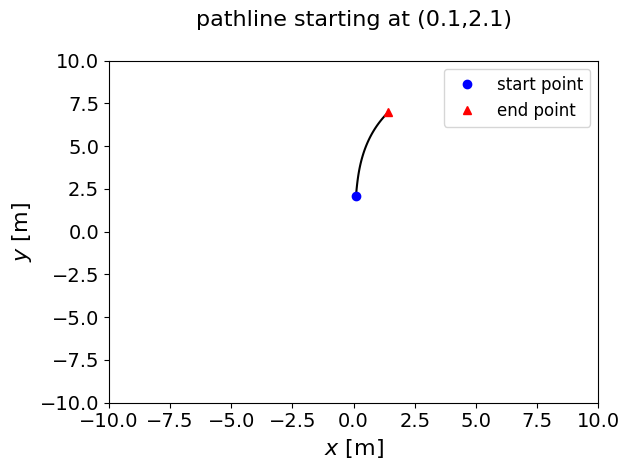

In [14]:
plot_pathline(1.2)

In [15]:
interact(plot_pathline, t = widgets.FloatSlider(value=tfinal/5,
                                                min=t0,
                                                max=tfinal,
                                                step=(tfinal-t0)/50),
                                                t0 = fixed(0));

interactive(children=(FloatSlider(value=0.6, description='t', max=3.0, step=0.06), Text(value='solid', descrip…

## A streakline

Now things get messy.

The streakline is the collection of **endpoints** of pathlines, all starting at the **same** initial point, but at _different_ times (one after each other).

We can use our pathline visualization above to devlop a streamline.

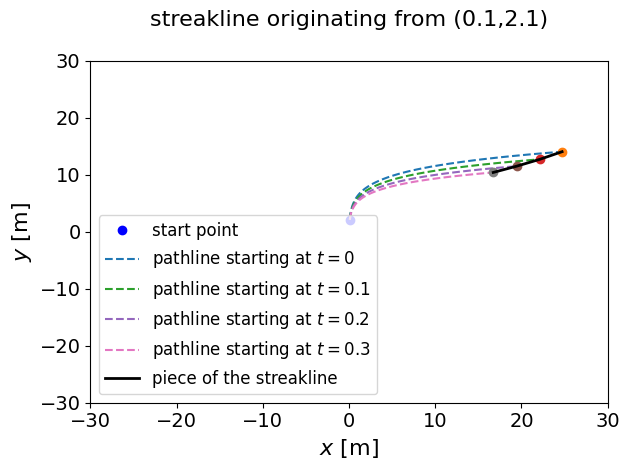

In [16]:
# define the length of the square domain to show the pathlines on
length = 30

# define the plotting figure and its axes
fig, ax = plt.subplots(tight_layout=True)
ax.set(xlim=(-length, length), ylim=(-length, length))
ax.set_ylabel('$y$ [m]')
ax.set_xlabel('$x$ [m]')
ax.set_title('streakline originating from (' + str(x0) + ',' + str(y0) + ')')

t_final = 1.9

pathline1 = spint.solve_ivp(pathline_ode, [0, t_final], [x0, y0],
                            t_eval=np.linspace(0,t_final,100),
                            dense_output=True)
pathline2 = spint.solve_ivp(pathline_ode, [0.1, t_final], [x0, y0],
                            t_eval=np.linspace(0.1,t_final,100),
                            dense_output=True)
pathline3 = spint.solve_ivp(pathline_ode, [0.2, t_final], [x0, y0],
                            t_eval=np.linspace(0.2,t_final,100),
                            dense_output=True)
pathline4 = spint.solve_ivp(pathline_ode, [0.3, t_final], [x0, y0],
                            t_eval=np.linspace(0.3,t_final,100),
                            dense_output=True)

# display the starting points with blue symbols
ax.plot(x0, y0, 'bo', label='start point')
ax.plot(pathline1.y[0], pathline1.y[1], '--', label='pathline starting at $t=0$')
ax.plot(pathline1.y[0][-1], pathline1.y[1][-1], 'o')
ax.plot(pathline2.y[0], pathline2.y[1], '--', label='pathline starting at $t=0.1$')
ax.plot(pathline2.y[0][-1], pathline2.y[1][-1], 'o')
ax.plot(pathline3.y[0], pathline3.y[1], '--', label='pathline starting at $t=0.2$')
ax.plot(pathline3.y[0][-1], pathline3.y[1][-1], 'o')
ax.plot(pathline4.y[0], pathline4.y[1], '--', label='pathline starting at $t=0.3$')
ax.plot(pathline4.y[0][-1], pathline4.y[1][-1], 'o')

ax.plot([pathline1.y[0][-1],pathline2.y[0][-1],pathline3.y[0][-1],pathline4.y[0][-1]],
        [pathline1.y[1][-1],pathline2.y[1][-1],pathline3.y[1][-1],pathline4.y[1][-1]],
        'k-', lw=2, label='piece of the streakline')

ax.legend()

plt.show()